## GAT

In [ ]:
import sys
 
sys.path.insert(0, '/home/amninder/Desktop/project/Folder_2/subfolder')

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import cudf
import torch

data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

ModuleNotFoundError: No module named 'sbc'

In [2]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))

In [4]:
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)

In [5]:
data = pd.concat((data, gw_data))
data = cudf.from_pandas(data)

In [6]:
data = data.reset_index(drop=True)

In [7]:
data.pop("index")

0           748793
1          1557412
2          1837234
3          1265411
4          1137003
            ...   
1819430     293517
1819431     448575
1819432     249374
1819433     261422
1819434     328808
Name: index, Length: 1819435, dtype: int64

## Creating edge index

In [12]:
edge_index = torch.zeros(2, data.shape[0], dtype=torch.long)
edge_index[0] = torch.arange(data.shape[0], dtype=torch.long)
edge_index[1] = torch.arange(data.shape[0], dtype=torch.long)
edge_index.shape

torch.Size([2, 1819435])

In [13]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

In [14]:
data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

In [15]:
X_features = torch.tensor(data[FEATURES].values.get()).type(torch.float32)
y = torch.tensor(data["Label"].values.get()).type(torch.long)

In [16]:
from dataAnalysis.FeatureImportance import normalize

X_features = normalize(X_features)

In [19]:
import numpy as np
def ratio_bool_switch(tensor, ratio = 0.8):
    random = np.random.uniform(0, 1 ,tensor.shape[0])
    val_ratio_mask = (random >= 0.8)
    train_ratio_mask = (random < 0.8)
    val_mask = np.logical_and(tensor.tolist(), val_ratio_mask.tolist())
    train_mask = np.logical_and(tensor.tolist(), train_ratio_mask.tolist())
    return torch.from_numpy(train_mask).type(torch.bool), torch.from_numpy(val_mask).type(torch.bool)

In [20]:
from torch_geometric.data import Data

train_mask_ser = data["Set"] != "Validation"
train_mask, val_mask = ratio_bool_switch(train_mask_ser.values)
test_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values.get(), (data["Center"] == "Leipzig").values.get())).type(torch.bool)
test_gw_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values.get(), (data["Center"] == "Greifswald").values.get())).type(torch.bool)
graph = Data(x=X_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=edge_index,
             test_gw_mask = test_gw_mask)

In [21]:
test_gw_mask.sum() + test_mask.sum()+val_mask.sum()+train_mask.sum()

tensor(1819435)

In [22]:
graph

Data(x=[1819435, 7], edge_index=[2, 1819435], y=[1819435], train_mask=[1819435], test_mask=[1819435], val_mask=[1819435], test_gw_mask=[1819435])

In [23]:
graph = graph.cpu()

In [24]:
from torch_geometric.loader import NeighborLoader

kwargs = {
    "num_neighbors":[-1] * 2,
    "batch_size":50_000
}
loader = NeighborLoader(
    graph,
    input_nodes=graph.train_mask,
    **kwargs
)
val_loader = NeighborLoader(
    graph,
    input_nodes=graph.val_mask,
    **kwargs
)

In [33]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# graph = graph.to(device)
WEIGHT = torch.tensor([664*4/5])#
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:0


In [34]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, global_add_pool, SAGEConv
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        HEADS = 5
        
#         conv_1= GATConv(input_dim, hidden_dim,heads=HEADS, add_self_loops = False)
#         conv_end = GATConv((-1,-1), out_channels,add_self_loops = False)
        conv_1= SAGEConv(input_dim, hidden_dim,normalize=True)
        conv_end = SAGEConv((-1,-1), out_channels)
        
        self.conv_1 = conv_1
        self.conv_end = conv_end
        

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = x.type(torch.float)
        x = self.conv_1(x, edge_index)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

In [41]:
import torch 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000 #40000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5 
        self.val_loss = []
        self.train_loss = []
        self.epochs = self.MAX_EPOCHS
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(val_loader):
                graph = graph.to(device)
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.val_mask], graph.y[graph.val_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.val_loss.append(avg_loss)
            if avg_loss > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = avg_loss

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(loader):
                graph = graph.to(device)
                self.model.train()
                self.optimizer.zero_grad()
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.train_mask], graph.y[graph.train_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(acc_loss/batch_size)
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                self.epochs = epoch + 1
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(range(len(self.train_loss)), self.train_loss, 'g', label='Training loss')
        plt.plot(range(len(self.val_loss)), self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [42]:
model_wrapper = ModelWrapper(graph)
model_wrapper.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1308


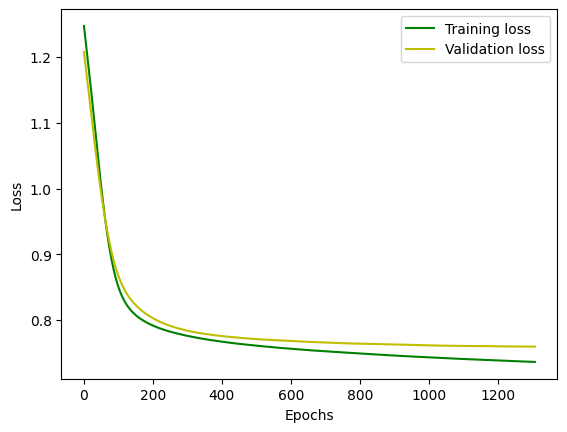

In [43]:
model_wrapper.plot_loss()

In [44]:
model = model_wrapper.get_model()
graph = graph.cpu()
model = model.cpu()

In [45]:
from dataAnalysis.Metrics import Evaluation

y_dict = Evaluation.create_y_dict(model.predict(graph, test_mask), model.predict_proba(graph, test_mask) , graph.y[test_mask])
y_dict_gw = Evaluation.create_y_dict(model.predict(graph, test_gw_mask), model.predict_proba(graph, test_gw_mask) , graph.y[test_gw_mask])

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.052306,0.797884,0.448819,0.010188,0.878488,0.017151
1,Greifswald,0.032611,0.685952,0.409327,0.005105,0.811593,0.006263


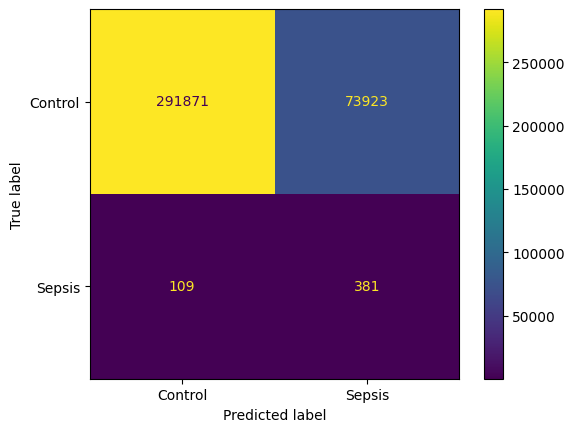

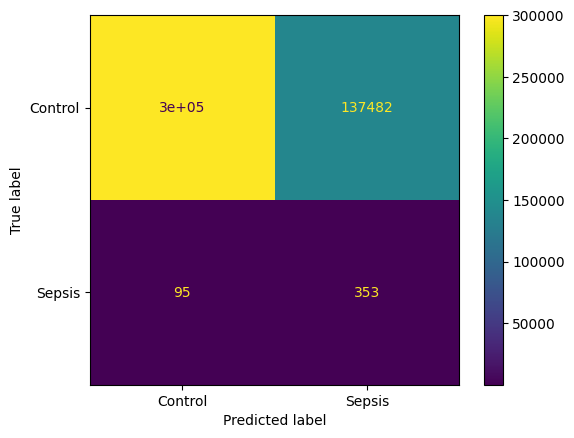

In [46]:
from dataAnalysis.Metrics import Evaluation

Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_mask), graph.y[test_mask])
Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_gw_mask), graph.y[test_gw_mask])
Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw)

In [55]:
from IPython.display import Audio
sound_file = './finish_sound.mp3'
Audio(sound_file, autoplay=True)

In [56]:
##TODO:
# - change weight
# - gradients as features
# - different learning rate and number of layers
# - general architecture- less neurons but linear layer before and after convs? 
#       -adding hidden layers with each others for more stable training (guaranteed only when hidden dim is euqal betwene layers)
# - GATv2
# - MIMIC und Greifswald
# - more features

In [ ]:
import time

for i in range(10000):
    time.sleep(60)
    print("Sleeping")

Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
S